# MIE524 - Lab 1 - Spark Warm-up


## Setup

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=b3bc7c1bfd22c35cf82ec067fff03f0dd291b22878682489a9f247367f961009
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Word Count with Spark
We will work with the *pg100.txt* file which contains a copy of the complete works of Shakespeare.

In [3]:
id='1FV9oO0opIaww85HGR0Oe_mv6FSOmzVZ6'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('pg100.txt')

In [4]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [6]:
spark

Load the dataset:

In [7]:
# txt = spark.read.text("pg100.txt")
rdd = spark.sparkContext.textFile("pg100.txt")

In [8]:
rdd.take(10)

['The Project Gutenberg EBook of The Complete Works of William Shakespeare, by',
 'William Shakespeare',
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 '',
 '** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **',
 '**     Please follow the copyright guidelines in this file.     **']

### Remove punctuation and transform all words to lower case using **map ()**

In [ ]:
def lower_str(x):
  lowercase_str = x.lower()
  return lowercase_str

rdd = rdd.map(lower_str)

def strip_punc(x):
  punc = '!"#$%&\'()*+,.:;<=>?@[\\]^_`{|}-~'
  for c in punc:
    x_clean = x.replace(c, '')
  return x_clean

rdd = rdd.map(strip_punc)

In [ ]:
rdd.take(10)

['the project gutenberg ebook of the complete works of william shakespeare, by',
 'william shakespeare',
 '',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org',
 '',
 '** this is a copyrighted project gutenberg ebook, details below **',
 '**     please follow the copyright guidelines in this file.     **']

### Split sentences in words using **flatMap()**

In [ ]:
rdd = rdd.flatMap(lambda line: line.split(" "))
rdd.take(10)

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'complete',
 'works',
 'of',
 'william']

### Exclude whitespaces using **filter()**

In [ ]:
rdd = rdd.filter(lambda x:x!='')
rdd.take(10)

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'complete',
 'works',
 'of',
 'william']

### Count how many times each word occurs using **reduceByKey()**

In [ ]:
# initialize (key,val) pair RDD
rdd_count = rdd.map(lambda word:(word,1))
rdd_count.take(10)

[('the', 1),
 ('project', 1),
 ('gutenberg', 1),
 ('ebook', 1),
 ('of', 1),
 ('the', 1),
 ('complete', 1),
 ('works', 1),
 ('of', 1),
 ('william', 1)]

In [ ]:
rdd_count_rbk = rdd_count.reduceByKey(lambda x,y:(x+y)).sortByKey()
rdd_count_rbk.take(10)

[('"', 241),
 ('"\'tis', 1),
 ('"a', 4),
 ('"air,"', 1),
 ('"alas,', 1),
 ('"amen"', 2),
 ('"amen"?', 1),
 ('"amen,"', 1),
 ('"and', 1),
 ('"aroint', 1)]

### Rank by frequency of occurence

In [ ]:
# switch (key,val) pairs as (val,key)
rdd_count_rbk = rdd_count_rbk.map(lambda x:(x[1],x[0]))
rdd_count_rbk.take(10)

[(241, '"'),
 (1, '"\'tis'),
 (4, '"a'),
 (1, '"air,"'),
 (1, '"alas,'),
 (2, '"amen"'),
 (1, '"amen"?'),
 (1, '"amen,"'),
 (1, '"and'),
 (1, '"aroint')]

In [ ]:
rdd_count_rbk.sortByKey(False).take(10)

[(27730, 'the'),
 (26099, 'and'),
 (19540, 'i'),
 (18762, 'to'),
 (18126, 'of'),
 (14436, 'a'),
 (12456, 'my'),
 (10730, 'in'),
 (10696, 'you'),
 (10501, 'that')]

# Oxford Covid-19 Government Response Tracker

We will analyze the Oxford Covid-19 Government Response Tracker data available [here](https://github.com/OxCGRT/covid-policy-tracker/tree/master).


The Oxford Covid-19 Government Response Tracker (OxCGRT) collects systematic information on policy measures that governments have taken to tackle COVID-19.

The different policy responses are tracked since 1 January 2020, cover more than 180 countries and are coded into 23 indicators, such as school closures, travel restrictions, vaccination policy. These policies are recorded on a scale to reflect the extent of government action, and scores are aggregated into a suite of policy indices. The data can help decision-makers and citizens understand governmental responses in a consistent way, aiding efforts to fight the pandemic.

https://www.bsg.ox.ac.uk/research/covid-19-government-response-tracker


**OxCGRT** [Get the dataset here](https://drive.google.com/file/d/1ECXsyH6HtWjTa8VpHweFQs1ceq29niFo/view?usp=share_link)


In [9]:
id='1ECXsyH6HtWjTa8VpHweFQs1ceq29niFo'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('OxCGRT_nat_latest.csv')

In [11]:
# kill the previous instance of spark so we can start a new one
spark.stop()

In [12]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Load the dataset:

In [13]:
OxCGRT_latest = spark.read.option("header", True).csv("OxCGRT_nat_latest.csv")


Check the schema:

In [ ]:
OxCGRT_latest.printSchema()

root
 |-- CountryName: string (nullable = true)
 |-- CountryCode: string (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionCode: string (nullable = true)
 |-- Jurisdiction: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- C1M_School closing: string (nullable = true)
 |-- C1M_Flag: string (nullable = true)
 |-- C2M_Workplace closing: string (nullable = true)
 |-- C2M_Flag: string (nullable = true)
 |-- C3M_Cancel public events: string (nullable = true)
 |-- C3M_Flag: string (nullable = true)
 |-- C4M_Restrictions on gatherings: string (nullable = true)
 |-- C4M_Flag: string (nullable = true)
 |-- C5M_Close public transport: string (nullable = true)
 |-- C5M_Flag: string (nullable = true)
 |-- C6M_Stay at home requirements: string (nullable = true)
 |-- C6M_Flag: string (nullable = true)
 |-- C7M_Restrictions on internal movement: string (nullable = true)
 |-- C7M_Flag: string (nullable = true)
 |-- C8EV_International travel controls: string (nullabl

Get a sample with take():

In [ ]:
OxCGRT_latest.take(3)

[Row(CountryName='Aruba', CountryCode='ABW', RegionName=None, RegionCode=None, Jurisdiction='NAT_TOTAL', Date='20200101', C1M_School closing='0.00', C1M_Flag=None, C2M_Workplace closing='0.00', C2M_Flag=None, C3M_Cancel public events='0.00', C3M_Flag=None, C4M_Restrictions on gatherings='0.00', C4M_Flag=None, C5M_Close public transport='0.00', C5M_Flag=None, C6M_Stay at home requirements='0.00', C6M_Flag=None, C7M_Restrictions on internal movement='0.00', C7M_Flag=None, C8EV_International travel controls='0.00', E1_Income support='0.00', E1_Flag=None, E2_Debt/contract relief='0.00', E3_Fiscal measures='0.00', E4_International support='0.00', H1_Public information campaigns='0.00', H1_Flag=None, H2_Testing policy='0.00', H3_Contact tracing='0.00', H4_Emergency investment in healthcare='0.00', H5_Investment in vaccines='0.00', H6M_Facial Coverings='0.00', H6M_Flag=None, H7_Vaccination policy='0.00', H7_Flag=None, H8M_Protection of elderly people='0.00', H8M_Flag=None, M1_Wildcard=None, V

Get a formatted sample with `show()`:

In [ ]:
OxCGRT_latest.show()

+-----------+-----------+----------+----------+------------+--------+------------------+--------+---------------------+--------+------------------------+--------+------------------------------+--------+--------------------------+--------+-----------------------------+--------+-------------------------------------+--------+----------------------------------+-----------------+-------+-----------------------+------------------+------------------------+-------------------------------+-------+-----------------+------------------+-------------------------------------+-------------------------+--------------------+--------+---------------------+-------+--------------------------------+--------+-----------+-----------------------------------+----------------------------------+-------------------------------------------------------------------------------+--------------------------------------------------------------------+--------------------------------------------------+-------------+-------

In [ ]:
print("In total there are {0} records".format(OxCGRT_latest.count()))

In total there are 205011 records


You can check the levels on each policy [here](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md).

## Q1: Which are the top 20 countries that had their schools closed for the longest period of time?
C1M_School closing = 3

In [ ]:
school_closing_counts = OxCGRT_latest.where("`C1M_School closing` = 3")\
                                    .groupBy("CountryName")\
                                    .agg(count("*").alias("C1M_School_closing_count"))\
                                    .sort(desc("C1M_School_closing_count"))
school_closing_counts.show()

+------------+------------------------+
| CountryName|C1M_School_closing_count|
+------------+------------------------+
|       China|                     844|
|     Myanmar|                     730|
| Philippines|                     621|
|   Venezuela|                     601|
|      Kuwait|                     581|
|      Mexico|                     578|
|  Bangladesh|                     575|
|      Canada|                     534|
|    Honduras|                     531|
|      Panama|                     530|
|    Mongolia|                     511|
|Saudi Arabia|                     505|
|        Cuba|                     487|
|        Iraq|                     475|
|       Chile|                     465|
|       India|                     461|
|   Palestine|                     447|
|     Ukraine|                     440|
|        Iran|                     436|
|    Malaysia|                     419|
+------------+------------------------+
only showing top 20 rows



In [ ]:
OxCGRT_latest.createOrReplaceTempView("OxCGRT_latest")

query = """
SELECT CountryName, count(*) as C1M_School_closing_count
FROM OxCGRT_latest
WHERE `C1M_School closing` = 3
GROUP BY CountryName
ORDER BY C1M_School_closing_count DESC
"""

school_closing_counts = spark.sql(query)
school_closing_counts.show()

+------------+------------------------+
| CountryName|C1M_School_closing_count|
+------------+------------------------+
|       China|                     844|
|     Myanmar|                     730|
| Philippines|                     621|
|   Venezuela|                     601|
|      Kuwait|                     581|
|      Mexico|                     578|
|  Bangladesh|                     575|
|      Canada|                     534|
|    Honduras|                     531|
|      Panama|                     530|
|    Mongolia|                     511|
|Saudi Arabia|                     505|
|        Cuba|                     487|
|        Iraq|                     475|
|       Chile|                     465|
|       India|                     461|
|   Palestine|                     447|
|     Ukraine|                     440|
|        Iran|                     436|
|    Malaysia|                     419|
+------------+------------------------+
only showing top 20 rows



Move to Pandas

In [ ]:
school_closing_counts_pd = school_closing_counts.toPandas()
school_closing_counts_pd.head()

,CountryName,C1M_School_closing_count
0,China,844
1,Myanmar,730
2,Philippines,621
3,Venezuela,601
4,Kuwait,581


Text(0, 0.5, 'Number of Days Schools Closed')

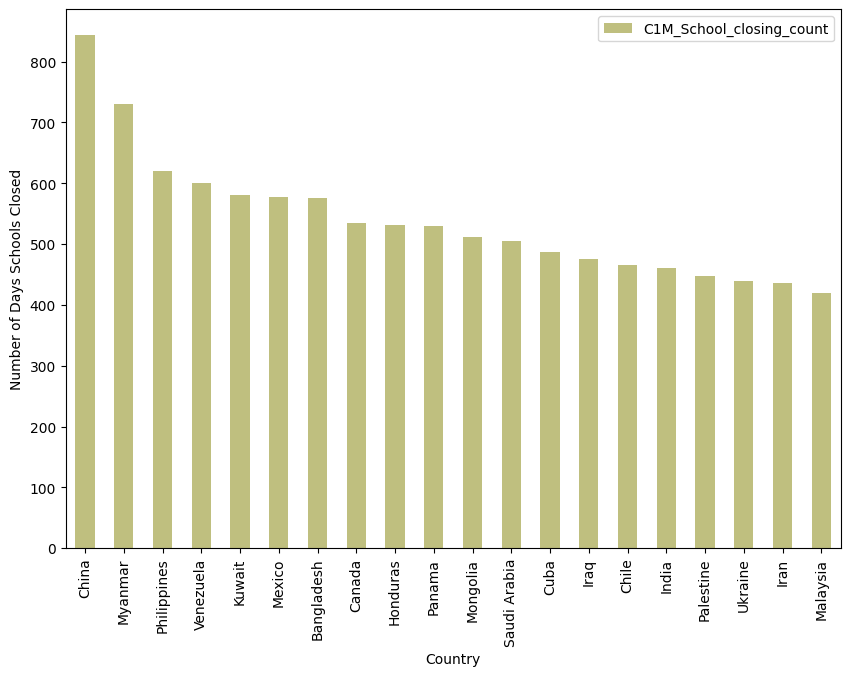

In [ ]:
pl = school_closing_counts_pd.head(20).plot(kind="bar",
                            x="CountryName", y="C1M_School_closing_count",
                            figsize=(10, 7), alpha=0.5, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Days Schools Closed")


## Q2: What are the total number of confirmed cases?
Find these values for CountryName IN [Canada, United States, India, United Kingdom, China, Iran, Brazil, Australia, and South Africa].




First, get a lits of country names.

In [ ]:
confirmed_cases_countries = OxCGRT_latest.selectExpr(["CountryName", "to_date(Date,'yyyyMMdd') as Date", "ConfirmedCases", "GovernmentResponseIndex_Average"])\
                                        .where("CountryName IN ('Canada', 'United States', 'India', 'United Kingdom', 'China', 'Iran', 'Brazil', 'Australia', 'South Africa')")
confirmed_cases_countries.show()

+-----------+----------+--------------+-------------------------------+
|CountryName|      Date|ConfirmedCases|GovernmentResponseIndex_Average|
+-----------+----------+--------------+-------------------------------+
|  Australia|2020-01-01|          null|                           null|
|  Australia|2020-01-02|          null|                           null|
|  Australia|2020-01-03|          null|                           null|
|  Australia|2020-01-04|          null|                           null|
|  Australia|2020-01-05|          null|                           null|
|  Australia|2020-01-06|          null|                           null|
|  Australia|2020-01-07|          null|                           null|
|  Australia|2020-01-08|          null|                           null|
|  Australia|2020-01-09|          null|                           null|
|  Australia|2020-01-10|          null|                           null|
|  Australia|2020-01-11|          null|                         

In [ ]:
confirmed_cases_daily = confirmed_cases_countries.where("CountryName IN ('Canada', 'United States', 'India', 'United Kingdom', 'China', 'Iran', 'Brazil', 'Australia', 'South Africa')")\
                                    .toPandas()
confirmed_cases_daily.head()

,CountryName,Date,ConfirmedCases
0,Australia,2020-01-01,None
1,Australia,2020-01-02,None
2,Australia,2020-01-03,None
3,Australia,2020-01-04,None
4,Australia,2020-01-05,None


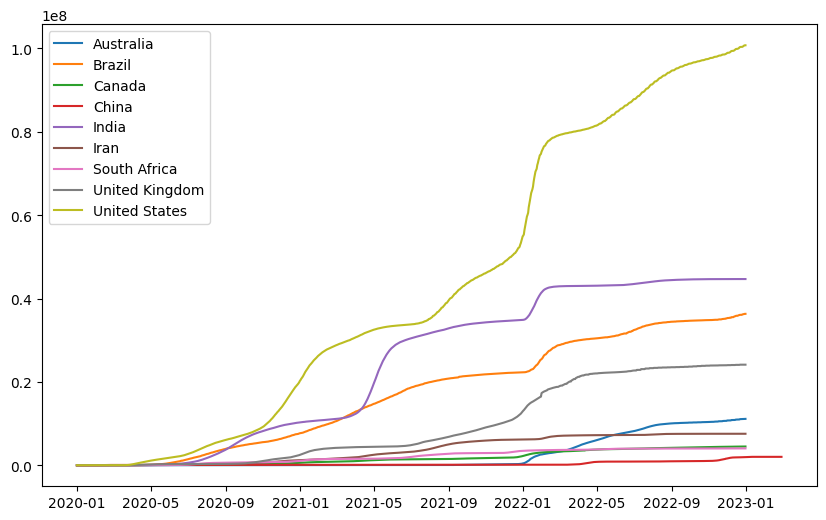

In [ ]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, confimed_case in confirmed_cases_daily.groupby("CountryName"):
    plt.plot(confimed_case["Date"], confimed_case["ConfirmedCases"].fillna(0), label=country)


plt.legend(loc='best')

## Q3: What are the daily confirmed cases?
The *ConfirmedCases* columns is a cumulative sum, we need to convert them to daily values first.

Find these values for CountryName IN [Canada, United States, India, United Kingdom, China, Iran, Brazil, Australia, and South Africa].

In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as f

window = Window.partitionBy("CountryName").orderBy("Date")

daily_confirmed_cases = confirmed_cases_countries.withColumn("ConfirmedCases", f.col("ConfirmedCases") - f.lag(f.col("ConfirmedCases"), 1, 0).over(window))

daily_confirmed_cases.show()

+-----------+----------+--------------+-------------------------------+
|CountryName|      Date|ConfirmedCases|GovernmentResponseIndex_Average|
+-----------+----------+--------------+-------------------------------+
|  Australia|2020-01-01|          null|                           null|
|  Australia|2020-01-02|          null|                           null|
|  Australia|2020-01-03|          null|                           null|
|  Australia|2020-01-04|          null|                           null|
|  Australia|2020-01-05|          null|                           null|
|  Australia|2020-01-06|          null|                           null|
|  Australia|2020-01-07|          null|                           null|
|  Australia|2020-01-08|          null|                           null|
|  Australia|2020-01-09|          null|                           null|
|  Australia|2020-01-10|          null|                           null|
|  Australia|2020-01-11|          null|                         

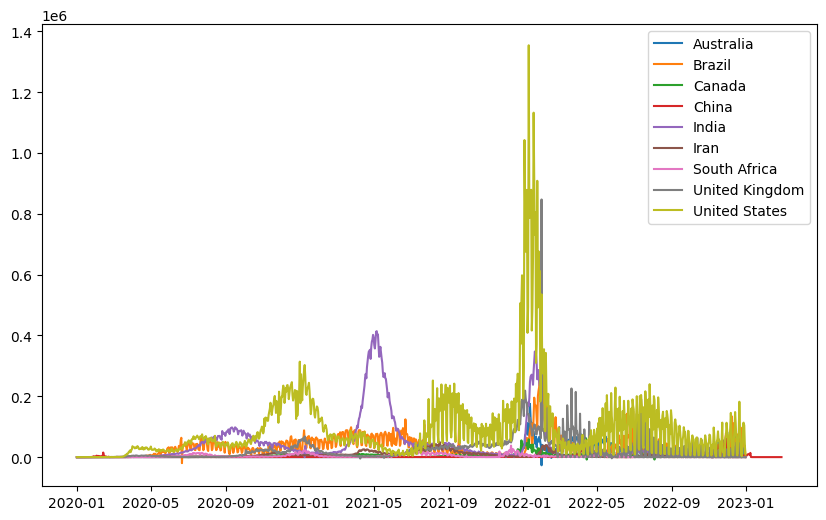

In [ ]:
daily_confirmed_cases_df = daily_confirmed_cases.toPandas()

fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, confimed_case in daily_confirmed_cases_df.groupby("CountryName"):
    plt.plot(confimed_case["Date"], confimed_case["ConfirmedCases"].fillna(0), label=country)


plt.legend(loc='best')

## Q4: Plot the Government Response Index vs the daily number of confirmed cases.

Create a plot for each of the following countries [Canada, United States, India, United Kingdom, China, Iran, Brazil, Australia, and South Africa].




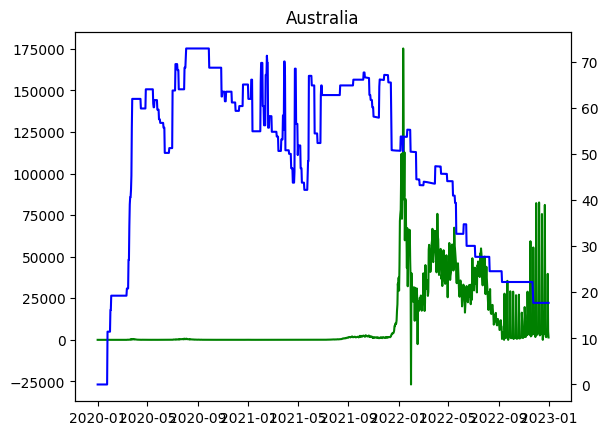

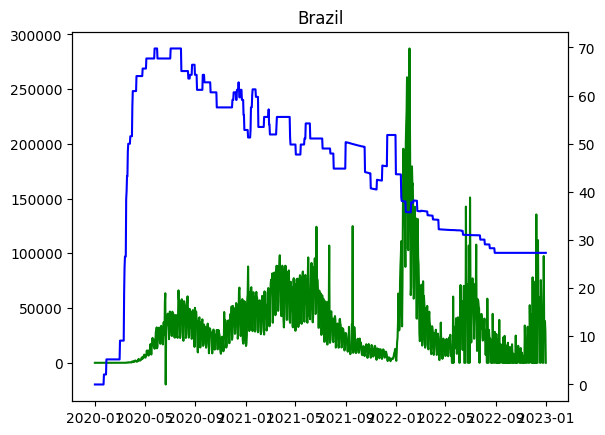

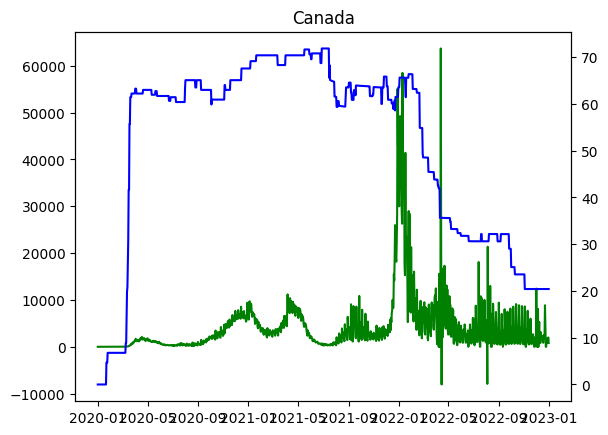

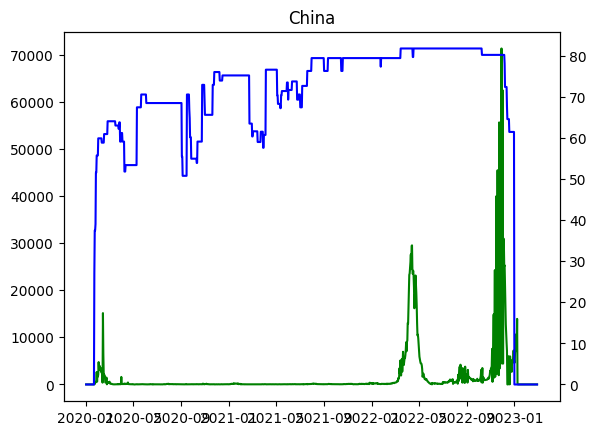

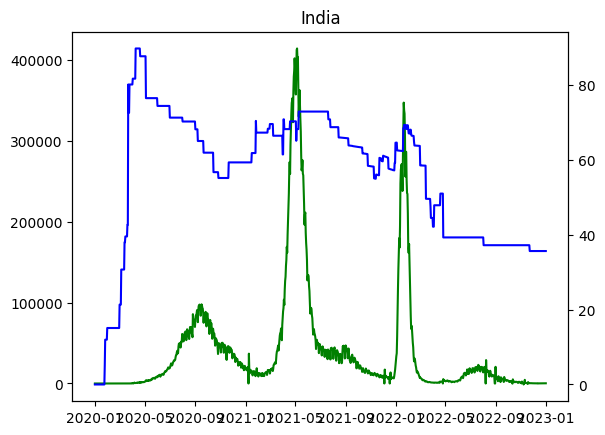

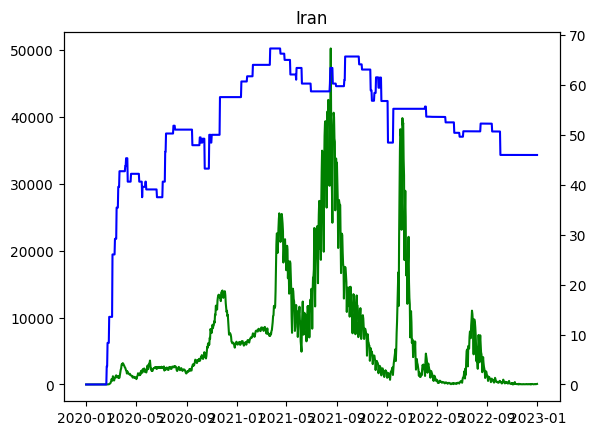

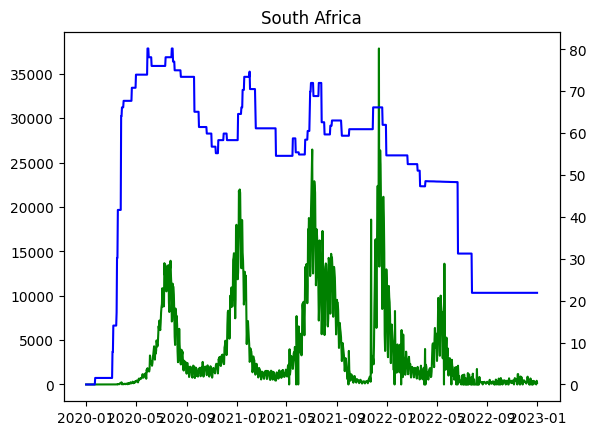

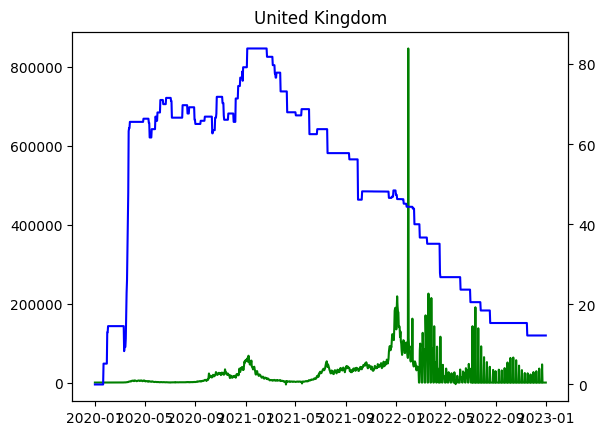

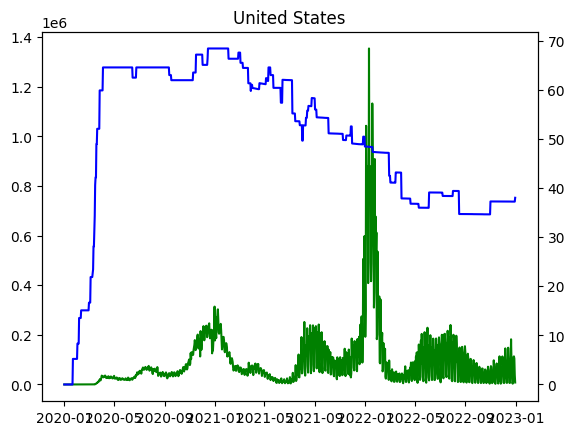

In [ ]:
for country, confimed_case in daily_confirmed_cases_df.groupby("CountryName"):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(confimed_case["Date"], confimed_case["ConfirmedCases"].fillna(0), 'g-')
    ax2.plot(confimed_case["Date"], confimed_case["GovernmentResponseIndex_Average"].fillna(0), 'b-')
    plt.title(country)
    plt.show()